<a href="https://colab.research.google.com/github/Inha-AI/DACON-semiconductor-competition/blob/feature%2FYoonSungLee/submission_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.0.1-cp36-none-any.whl size=10032 sha256=154cc6a24292ddb576a31125ae54c7e5eb49e207ca681777a26ff1dab1c80294
  Stored in directory: /root/.cache/pip/wheels/1d/0d/3b/6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built bayesian-optimization


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
df_train = pd.read_csv('/gdrive/My Drive/DACON-semiconductor-competition/dataset/train.csv')
df_test = pd.read_csv('/gdrive/My Drive/DACON-semiconductor-competition/dataset/test.csv')

In [0]:
# 데이터 자료형을 적절히 변형시켜 데이터의 크기를 줄이는 방법

# for col in df_train.columns:
#     col_type = df_train[col].dtypes
#     min1 = df_train[col].min()
#     max1 = df_train[col].max()
#     if str(col_type)[:3] == 'int':
#         df_train[col] = df_train[col].astype(np.int16)
#     else:
#         if min1 > np.finfo(np.float16).min and max1 < np.finfo(np.float16).max:
#             df_train[col] = trdf_trainain[col].astype(np.float16)
#         elif min1 > np.finfo(np.float32).min and max1 < np.finfo(np.float32).max:
#             df_train[col] = df_train[col].astype(np.float32)
#         else:
#             df_train[col] = df_train[col].astype(np.float64)

In [0]:
# 독립변수와 종속변수를 분리합니다.

train_X = df_train.iloc[:,4:]
train_Y = df_train.iloc[:,0:4]
test_X = df_test.iloc[:,1:]

In [0]:
# train set을 shuffle하여 다시 train set과 validation set으로 분리합니다.

train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.25)

# Model 10

* 11 layers
* (239, 252, 265, 178, 91) units, he_normal, swish
* BatchNormalization
* Adam(0.001)
* epochs 200
* batch_size 630
<br><br>
* BayesianOptimization을 사용하여 최적의 learning_rate와 batch_size 추출
* 입력 데이터는 음수값을 포함하고 있으므로 작은 음수값들은 살리기 위해 activation function을 swish로 변경

In [0]:
# 케라스를 통해 모델 생성을 시작합니다.

def create_model():
    model = Sequential()
    model.add(Dense(units=239, input_dim=226, kernel_initializer='he_normal'))
    model.add(Dense(units=239, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation(swish))
    model.add(Dense(units=252, kernel_initializer='he_normal'))
    model.add(Dense(units=252, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation(swish))
    model.add(Dense(units=265, kernel_initializer='he_normal'))
    model.add(Dense(units=265, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation(swish))
    model.add(Dense(units=178, kernel_initializer='he_normal'))
    model.add(Dense(units=178, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation(swish))
    model.add(Dense(units=91, kernel_initializer='he_normal'))
    model.add(Dense(units=91, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation(swish))
    model.add(Dense(units=4, activation='linear'))

    return model


# Activation Function 정의

def swish(x) :
    return x * keras.activations.sigmoid(x)


# 특정한 초기 학습률 및 배치 사이즈 하에서 학습을 수행한 후, 검증 성능을 출력하는 목적 함수 정의

def train_and_validate(learning_rate, batch_size):
    model = create_model()
    adam = keras.optimizers.Adam(learning_rate)
    model.compile(loss='mae', optimizer=adam, metrics=['accuracy'])
    hist = model.fit(train_X, train_Y, epochs=20, batch_size=int(batch_size),
                    validation_data=(val_X, val_Y))
    best_val_score = max(hist.history['val_acc'])

    return best_val_score

In [0]:
# BayesianOptimization 객체 생성, 실행 및 최종 결과 출력
# 특정 모델에서 최적의 learning_rate와 batch_size를 찾기 위함
# model.fit() 의 verbose를 0으로 설정하여 "Buffered data was truncated after reaching the output size limit." 문제 해결

bayes_optimizer = BayesianOptimization(
    f=train_and_validate,
    pbounds={
        'learning_rate' : (0.001, 0.1),
        'batch_size' : (500,1000)
    },
    random_state=0,
    verbose=2
)

bayes_optimizer.maximize(init_points=3, n_iter=27, acq='ei',xi=0.01)

for i, res in enumerate(bayes_optimizer.res):
    print('iteration {}: \n\t{}'.format(i, res))
print('Final result: ', bayes_optimizer.max)

|   iter    |  target   | batch_... | learni... |
-------------------------------------------------









Train on 607500 samples, validate on 202500 samples
Epoch 1/20





607500/607500 [==============================] - 26s 43us/step - loss: 57.2700 - acc: 0.3511 - val_loss: 61.1310 - val_acc: 0.3638
Epoch 2/20
607500/607500 [==============================] - 15s 25us/step - loss: 38.6549 - acc: 0.5834 - val_loss: 49.7541 - val_acc: 0.5489
Epoch 3/20
607500/607500 [==============================] - 15s 24us/step - loss: 25.7873 - acc: 0.7323 - val_loss: 37.2670 - val_acc: 0.6252
Epoch 4/20
607500/607500 [==============================] - 15s 25us/step - loss: 20.8406 - acc: 0.7811 - val_loss: 26.7745 - val_acc: 0.7200
Epoch 5/20
607500/607500 [==============================] - 15s 25us/step - loss: 17.7931 - acc: 0.8105 - val_loss: 22.7330 - val_acc: 0.7629
Epoch 6/20
607500/607500 [==============================] - 15s 25us/step - loss: 15.6509 - acc: 0.8311 - val_loss: 19.9171 

In [0]:
# BayesianOptimization 객체 생성, 실행 및 최종 결과 출력
# 특정 모델에서 최적의 learning_rate와 batch_size를 찾기 위함
# 마찬가지로 오류 발생

bayes_optimizer = BayesianOptimization(
    f=train_and_validate,
    pbounds={
        'learning_rate' : (0.001, 0.1),
        'batch_size' : (500,1000)
    },
    random_state=0,
    verbose=1
)

bayes_optimizer.maximize(init_points=3, n_iter=27, acq='ei',xi=0.01)

for i, res in enumerate(bayes_optimizer.res):
    print('iteration {}: \n\t{}'.format(i, res))
print('Final result: ', bayes_optimizer.max)

|   iter    |  target   | batch_... | learni... |
-------------------------------------------------
Train on 607500 samples, validate on 202500 samples
Epoch 1/20
607500/607500 [==============================] - 31s 51us/step - loss: 55.2841 - acc: 0.3649 - val_loss: 65.9277 - val_acc: 0.3350
Epoch 2/20
607500/607500 [==============================] - 17s 27us/step - loss: 39.7310 - acc: 0.5721 - val_loss: 59.9574 - val_acc: 0.4360
Epoch 3/20
607500/607500 [==============================] - 16s 27us/step - loss: 27.5709 - acc: 0.7136 - val_loss: 37.1839 - val_acc: 0.6202
Epoch 4/20
607500/607500 [==============================] - 16s 27us/step - loss: 22.2966 - acc: 0.7662 - val_loss: 31.3564 - val_acc: 0.6654
Epoch 5/20
607500/607500 [==============================] - 16s 27us/step - loss: 19.0175 - acc: 0.7956 - val_loss: 24.3705 - val_acc: 0.7399
Epoch 6/20
607500/607500 [==============================] - 16s 27us/step - loss: 16.6751 - acc: 0.8186 - val_loss: 20.1325 - val_acc: 0.7

In [0]:
print('Final result: ', bayes_optimizer.max)

Final result:  {'target': 0.938355541283996, 'params': {'batch_size': 622.4291036969094, 'learning_rate': 0.0013658127139896644}}


In [0]:
model = create_model()

In [0]:
adam = keras.optimizers.Adam(0.001)
model.compile(loss='mae', optimizer=adam, metrics=['accuracy'])

In [0]:
hist = model.fit(train_X, train_Y, epochs=200, batch_size=630,
                    validation_data=(val_X, val_Y))

Train on 607500 samples, validate on 202500 samples
Epoch 1/200
607500/607500 [==============================] - 35s 57us/step - loss: 105.9699 - acc: 0.2801 - val_loss: 66.0642 - val_acc: 0.2597
Epoch 2/200
607500/607500 [==============================] - 20s 34us/step - loss: 44.3766 - acc: 0.5170 - val_loss: 36.7647 - val_acc: 0.6344
Epoch 3/200
607500/607500 [==============================] - 20s 33us/step - loss: 22.9436 - acc: 0.7675 - val_loss: 22.3326 - val_acc: 0.7722
Epoch 4/200
607500/607500 [==============================] - 20s 33us/step - loss: 16.1465 - acc: 0.8332 - val_loss: 16.1079 - val_acc: 0.8304
Epoch 5/200
607500/607500 [==============================] - 21s 34us/step - loss: 13.3405 - acc: 0.8613 - val_loss: 12.5230 - val_acc: 0.8711
Epoch 6/200
607500/607500 [==============================] - 21s 34us/step - loss: 11.6178 - acc: 0.8788 - val_loss: 11.7844 - val_acc: 0.8809
Epoch 7/200
607500/607500 [==============================] - 20s 33us/step - loss: 10.518

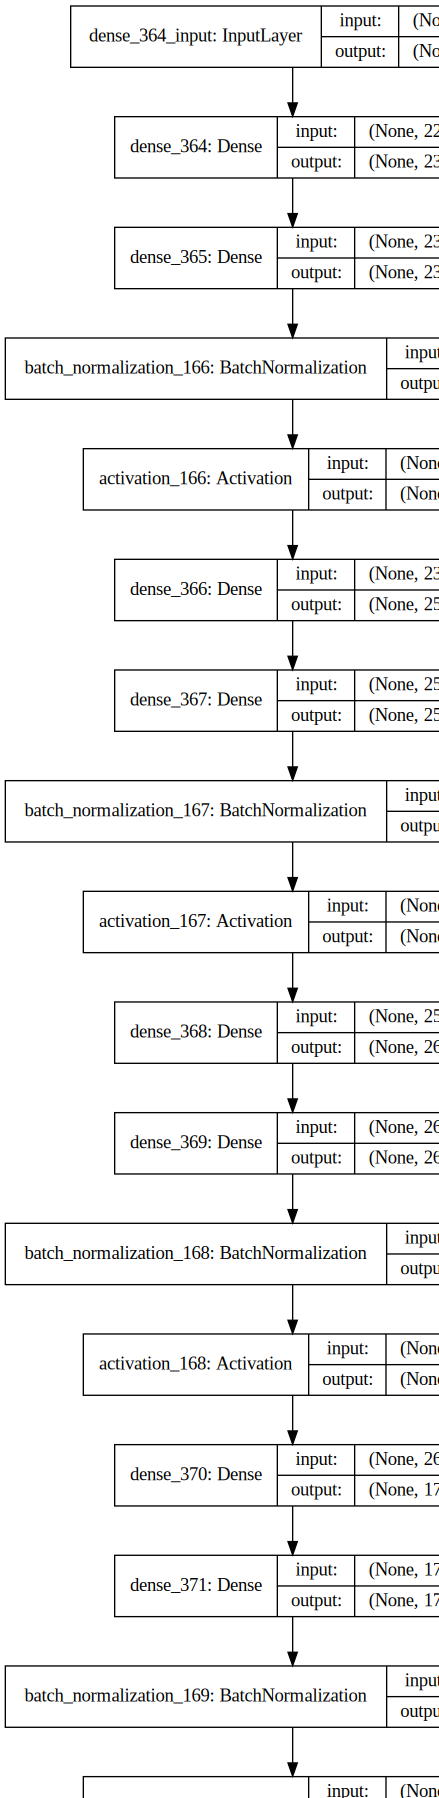

In [0]:
# 모델 아키텍처

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

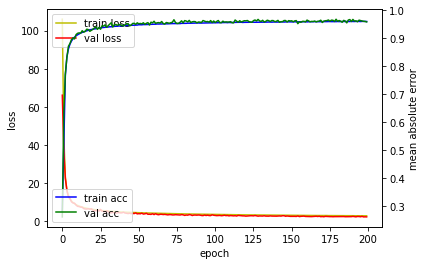

In [0]:
# 학습 과정

%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('mean absolute error')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [0]:
# 예측값을 생성합니다.

pred_test = model.predict(test_X)

In [0]:
# submission 파일을 생성합니다.
sample_sub = pd.read_csv('/gdrive/My Drive/DACON-semiconductor-competition/dataset/sample_submission.csv', index_col=0)
submission = sample_sub+pred_test
submission.to_csv('/gdrive/My Drive/DACON-semiconductor-competition/submission_10.csv')

### Bayesian Optimization
http://research.sualab.com/introduction/practice/2019/02/19/bayesian-optimization-overview-1.html<br>
http://research.sualab.com/introduction/practice/2019/04/01/bayesian-optimization-overview-2.html<br>

### Swish Activation
https://www.machinecurve.com/index.php/2019/05/30/why-swish-could-perform-better-than-relu/#todays-activation-functions